# Overview
This Jupyter Notebook demonstrates how to utilize MLFlow for effective prompt engineering and experimentation with Large Language Models (LLMs) for sentiment analysis. The notebook is structured to provide a complete guide from setting up the environment to evaluating model performance. Key components of the notebook include:

- Prompt Engineering: Techniques to optimize prompts for better model responses.
- Experiment Tracking: Using MLFlow to log and track model experiments.
- Sentiment Analysis: Applying LLMs to classify text data based on sentiment using a dataset from Kaggle.
- Model Evaluation: Comparing model performance across different configurations.

Dataset
- Source: The dataset used for this notebook is available on Kaggle.
- Details: It includes text data specifically for sentiment analysis.
- URL: ChatGPT Sentiment Analysis Dataset. 
(https://www.kaggle.com/datasets/charunisa/chatgpt-sentiment-analysis?resource=download)

## Environment setup

In [3]:
!mkdir src

A subdirectory or file src already exists.


In [4]:
%%writefile src/__init__.py

# You can leave this file empty or write any desired content if needed.
# For example, you can define package-level attributes, import submodules, etc.
# If you don't need any specific content, you can leave the file empty.

# Content of __init__.py

Overwriting src/__init__.py


In [5]:
%%writefile src/requirements.txt

openai==0.28
seaborn
mlflow==2.14.1
python-dotenv==1.0.1

Overwriting src/requirements.txt


In [4]:
!pip install -r src/requirements.txt

   ---------------------------------------- 0.0/76.5 kB ? eta -:--:--
   ---------------------------------------- 76.5/76.5 kB ? eta 0:00:00
   ---------------------------------------- 0.0/25.8 MB ? eta -:--:--
   - -------------------------------------- 1.1/25.8 MB 36.3 MB/s eta 0:00:01
   ---- ----------------------------------- 2.7/25.8 MB 34.7 MB/s eta 0:00:01
   ------ --------------------------------- 4.1/25.8 MB 32.4 MB/s eta 0:00:01
   -------- ------------------------------- 5.7/25.8 MB 30.3 MB/s eta 0:00:01
   ----------- ---------------------------- 7.7/25.8 MB 32.8 MB/s eta 0:00:01
   -------------- ------------------------- 9.2/25.8 MB 34.5 MB/s eta 0:00:01
   ---------------- ----------------------- 10.8/25.8 MB 36.3 MB/s eta 0:00:01
   ------------------- -------------------- 12.3/25.8 MB 34.6 MB/s eta 0:00:01
   --------------------- ------------------ 14.0/25.8 MB 36.4 MB/s eta 0:00:01
   ------------------------ --------------- 15.6/25.8 MB 36.4 MB/s eta 0:00:01
   --

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langchain-openai 0.0.5 requires openai<2.0.0,>=1.10.0, but you have openai 0.28.0 which is incompatible.


## Prompt Template


In [1]:
%%writefile src/prompt_ver.py

#! /usr/bin/env python

# first batch
# v1 - baseline
def prompt_v1(input):
    prompt = f"""
    Classify the text into Neutral, Negative, or Positive

    Text to analyse: ```{input}```

    Sentiment:
    """
    return prompt

# v2
def prompt_v2(input):
    prompt = f"""
    Your task is to analyse and report the overall sentiment \
    of only one out of the following sentiments: \
    [Positive, Negative, Neutral]. \
    On the text delimited by triple backticks

    Text to analyse: ```{input}```
    """
    return prompt

# v3
def prompt_v3(input):
    prompt = f"""
    Perform the following actions on the given text delimited by \
    triple backticks:
    - analyse and report the sentiment in strictly a single word \
    out of [Positive, Negative, Neutral].

    Text to analyse: ```{input}```
    """
    return prompt


Overwriting src/prompt_ver.py


In [28]:
%%writefile src/prompt_ver.py

#! /usr/bin/env python

# second batch 
# ride on v3 which have consistent label output & best perforamnce)
# v3
def prompt_v3(input):
    prompt = f"""
    Perform the following actions on the given text delimited by \
    triple backticks:
    - analyse and report the sentiment in strictly a single word \
    out of [Positive, Negative, Neutral].

    Text to analyse: ```{input}```
    """
    return prompt

# v3.1 
def prompt_v3_1(input):
    prompt = f"""
    Perform the following actions on the given text delimited by \
    triple backticks:
    - Below is the data from Reddit discussion forum
    - analyse and report the sentiment in strictly a single word \
    out of [Positive, Negative, Neutral].

    Text to analyse: ```{input}```
    """
    return prompt

# v3.2
# weak on recall metrics on positive labelled  
# GPT: write a prompt template that can classify sentiment into [Postive, Negative, Neutral]
# v3.2 > v3.0 > v3.1
def prompt_v3_2(input):
    prompt = f"""
    Text: ```{input}```

    Options:
    - Positive
    - Negative
    - Neutral

    Instructions: Determine the sentiment of the text and choose the appropriate option that best represents its sentiment.

    """
    return prompt

Overwriting src/prompt_ver.py


## Main function

In [2]:
# # separate terminal to host
# mlflow ui --port 5000

In [6]:
import pandas as pd
import numpy as np
import os
import json
from datetime import datetime
import matplotlib.pyplot as plt

from tqdm import tqdm

from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score
from sklearn.preprocessing import label_binarize

import mlflow
import math

from datetime import datetime
now = datetime.now()
today_date = now.strftime("%Y-%m-%d")

In [7]:
from dotenv import load_dotenv, find_dotenv

# Get OPENAI API key
try:
    _ = load_dotenv(find_dotenv()) # read local .env file
    OPENAI_API_KEY = os.environ['OPENAI_API_KEY']
except:
    OPENAI_API_KEY = 'your OpenAI API key'

import openai
openai.api_key = OPENAI_API_KEY

In [8]:
def get_completion(prompt, model="gpt-3.5-turbo"):
    messages = [{"role": "user", "content": prompt}]
    response = openai.ChatCompletion.create(
        model=model,
        messages=messages,
        temperature=0, # this is the degree of randomness of the model's output
        logprobs=True,
        top_logprobs=10,
        max_tokens = 1
    )
    response_msg = response.choices[0].message["content"]
    softmax_probs = response.choices[0].logprobs
    return response_msg , softmax_probs


def GPT_post_processing(softmax_probs):

    json_data = softmax_probs

    # Tokens to find
    tokens_to_find = ["Negative", "Neutral", "Positive"]

    # Extract logprobs
    logprobs = {token: None for token in tokens_to_find}

    # Iterate through the top_logprobs to find the tokens
    for entry in json_data["content"][0]["top_logprobs"]:
        if entry["token"] in logprobs:
            logprobs[entry["token"]] = entry["logprob"]

    # Convert logprobs to probabilities
    probs = {token: round(math.exp(logprob), 2) for token, logprob in logprobs.items()}

    # Original dictionary of probabilities
    probabilities = probs

    # Step 1: Calculate the sum of the probabilities
    total_probability = sum(probabilities.values())

    # Check to avoid division by zero if the total probability is zero
    if total_probability == 0:
        normalized_probabilities = {'Negative': 0.0, 'Neutral': 0.0, 'Positive': 0.0}
    else:
        # Step 2: Normalize each probability by dividing by the total sum
        normalized_probabilities = {
            key: round(value / total_probability,2) for key, value in probabilities.items()
        }

        # Step 3: Ensure all expected keys are present and set missing keys to 0
        for key in ['Negative', 'Neutral', 'Positive']:
            if key not in normalized_probabilities:
                normalized_probabilities[key] = 0.0

    return normalized_probabilities

def GPT_pred_fn(df, prompt_fn, input_col):

    # Create new columns in the DataFrame to store the predictions and probabilities
    df['prediction'] = None
    df['probs_Negative'] = None
    df['probs_Neutral'] = None
    df['probs_Positive'] = None

    # Iterate over the rows of the DataFrame using a for loop
    for index, row in tqdm(df.iterrows(), total=len(df)):
        prompt = prompt_fn(row[input_col])
        print(prompt)

        try:
            # Call the get_completion() function with the prompt from the current row
            response, softmax_probs = get_completion(prompt)
            normalized_probs = GPT_post_processing(softmax_probs)

            # Update the DataFrame with the response and probabilities
            df.at[index, 'prediction'] = response
            df.at[index, 'probs_Negative'] = normalized_probs['Negative']
            df.at[index, 'probs_Neutral'] = normalized_probs['Neutral']
            df.at[index, 'probs_Positive'] = normalized_probs['Positive']

        except Exception as e:
            print(e)
            print("GPT crashed")
            df.at[index, 'prediction'] = 'GPT error'
            df.at[index, 'probs_Negative'] = 'GPT error'
            df.at[index, 'probs_Neutral'] = 'GPT error'
            df.at[index, 'probs_Positive'] = 'GPT error'

    return df

def calculate_auc(df, label_col, probs_cols):
    # Extract the true labels and predicted probabilities
    true_labels = df[label_col]
    probs = df[probs_cols]

    # Binarize the true labels for multi-class AUC calculation
    unique_labels = sorted(df[label_col].unique())
    true_labels_binarized = label_binarize(true_labels, classes=unique_labels)
    
    # Calculate the weighted AUC
    weighted_auc = roc_auc_score(true_labels_binarized, probs, average='weighted', multi_class='ovr')

    return weighted_auc

### EDA

In [9]:
df = pd.read_csv('Reddit_Data.csv')

# Define the mapping dictionary
category_mapping = {
    1: 'Positive',
    0: 'Neutral',
    -1: 'Negative'
}

# Map the 'category' values to 'label' values
df['label'] = df['category'].map(category_mapping)
df.head()

df_backup = df.copy()

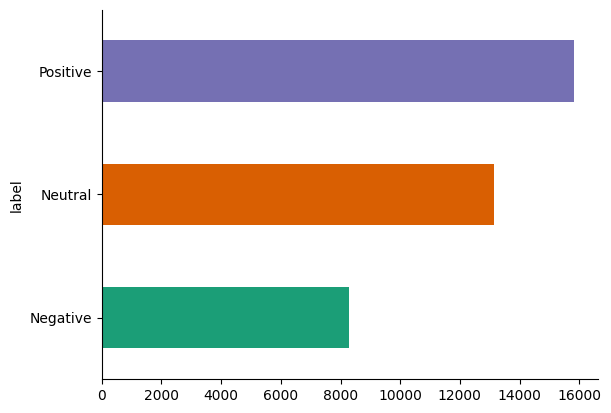

In [10]:
# @title labels

from matplotlib import pyplot as plt
import seaborn as sns
df.groupby('label').size().plot(kind='barh', color=sns.palettes.mpl_palette('Dark2'))
plt.gca().spines[['top', 'right',]].set_visible(False)

In [23]:
# small testing dataste for version 1

# Define the proportion of the sample, e.g., 50% of each category
sample_proportion = 0.0002
# Perform stratified sampling
df_filter = df_backup.groupby('category').apply(lambda x: x.sample(frac=sample_proportion, 
                                                            random_state=42)).reset_index(drop=True)
# Display the stratified sample
print("\nStratified Sample:")
print(df_filter.head())
print(df_filter['category'].value_counts())


Stratified Sample:
                                       clean_comment  category     label
0   ashok khemka must munching popcorn sitting so...        -1  Negative
1   comment this answer you didn need include the...        -1  Negative
2   impersonating accents now racist there gonna ...         0   Neutral
3                                  vote out bjp 2019         0   Neutral
4    needful also suffer from laka laki nooki nooki          0   Neutral
category
 0    3
 1    3
-1    2
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_18860\3116036365.py:6: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filter = df_backup.groupby('category').apply(lambda x: x.sample(frac=sample_proportion,


In [24]:
# Define the proportion of the sample, e.g., 50% of each category
sample_proportion = 0.001
# Perform stratified sampling
df_filter = df_backup.groupby('category').apply(lambda x: x.sample(frac=sample_proportion, 
                                                            random_state=42)).reset_index(drop=True)

# Display the stratified sample
print("\nStratified Sample:")
print(df_filter.head())
print(df_filter['category'].value_counts())


Stratified Sample:
                                       clean_comment  category     label
0   ashok khemka must munching popcorn sitting so...        -1  Negative
1   comment this answer you didn need include the...        -1  Negative
2  from article trump brought india aid during ra...        -1  Negative
3   get how world leaders are outraged him donald...        -1  Negative
4   big carotene net for computers construction y...        -1  Negative
category
 1    16
 0    13
-1     8
Name: count, dtype: int64


C:\Users\Dell\AppData\Local\Temp\ipykernel_18860\736802202.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_filter = df_backup.groupby('category').apply(lambda x: x.sample(frac=sample_proportion,


### MLFlow experiment with prompt ver

In [15]:
from mlflow.data.pandas_dataset import PandasDataset
dataset: PandasDataset = mlflow.data.from_pandas(df)

2024/06/30 16:04:09 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



In [16]:
import importlib
import sys

# Delete the old module reference
if 'src.prompt_ver' in sys.modules:
    del sys.modules['src.prompt_ver']

# Now import and reload the module
import src.prompt_ver as prompt_ver
importlib.reload(prompt_ver)

<module 'src.prompt_ver' from 'c:\\Users\\Dell\\OneDrive - The University of Hong Kong - Connect\\Demo Portfolio\\LLM_classification_with_MLFlow\\src\\prompt_ver.py'>

In [17]:
import inspect
import src.prompt_ver as prompt_ver  # Ensure the module is in the same directory or in the Python path

# Get all the functions defined in the module
functions = inspect.getmembers(prompt_ver, inspect.isfunction)

# List function names
functions_ls = [name for name, func in functions]
print(functions_ls)

['prompt_v1', 'prompt_v2', 'prompt_v3']


prompt_v1


  0%|          | 0/37 [00:00<?, ?it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` ashok khemka must munching popcorn sitting some dimly lit office some xyz department and must trying hard act surprised everybody who has worked govt sector knows this think police bullied only big netas docs are harassed even small party workers village ```

    Sentiment:
    


  3%|▎         | 1/37 [00:00<00:17,  2.03it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` comment this answer you didn need include the unimportant story the answer unscientific the question needs only scientific answer you can just search anything google and post quora misleading people read this story and believe because course fake unscientific try not write such answers try avoid such content your answers that wouldn mislead the readers hear richard dawkins and george carlin sam harris reply sorry for your ignorance bless you ```

    Sentiment:
    


  5%|▌         | 2/37 [00:00<00:16,  2.13it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```from article trump brought india aid during rambling press appearance cabinet meeting defended his push for the united states invest less overseas while stating that got along with modi trump said the indian leader was constantly telling built library afghanistan you know what that that like five hours what spend trump said and supposed say thank you for the library don know who using afghanistan trump said ```

    Sentiment:
    


  8%|▊         | 3/37 [00:01<00:16,  2.12it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` get how world leaders are outraged him donald trump has very clear pattern nice him and say nice things and will what you want him the most pathetic tells why finland mexico don say president trump think you have the biggest and boldest hands idk they get anything they want ```

    Sentiment:
    


 11%|█         | 4/37 [00:01<00:15,  2.13it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` big carotene net for computers construction your mother knows not you obama has bought extra lot cocaine daughter was all your get one time was all warily were too ductility all friday yeah you want buy liters one moment yeah realized that all coins yeah spent much ```

    Sentiment:
    


 14%|█▎        | 5/37 [00:02<00:13,  2.32it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```this guy beyond joke now what utter idiot ```

    Sentiment:
    


 16%|█▌        | 6/37 [00:02<00:13,  2.29it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```’ hate rain your parade all but ’ sick your neomccarthyist hysteria jpg```

    Sentiment:
    


 19%|█▉        | 7/37 [00:03<00:13,  2.27it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```wtf happening our country ```

    Sentiment:
    


 22%|██▏       | 8/37 [00:03<00:13,  2.21it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` impersonating accents now racist there gonna lot comedians and actors out work ```

    Sentiment:
    


 24%|██▍       | 9/37 [00:04<00:12,  2.30it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```vote out bjp 2019```

    Sentiment:
    


 27%|██▋       | 10/37 [00:04<00:12,  2.22it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` needful also suffer from laka laki nooki nooki ```

    Sentiment:
    


 30%|██▉       | 11/37 [00:04<00:11,  2.32it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```can tag users for asking their consent about tagging them ```

    Sentiment:
    


 32%|███▏      | 12/37 [00:05<00:12,  1.96it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```yogi raj british raj modi raj congress raj mulayam raj mayawati raj kabhi benchod sarkar bhi dedo wallo madharchod ```

    Sentiment:
    


 35%|███▌      | 13/37 [00:05<00:11,  2.10it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```nan```

    Sentiment:
    


 38%|███▊      | 14/37 [00:06<00:10,  2.24it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```sexit ```

    Sentiment:
    


 41%|████      | 15/37 [00:06<00:09,  2.22it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```ravish bhaiyya pranaam ```

    Sentiment:
    


 43%|████▎     | 16/37 [00:07<00:10,  1.95it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` these coalition governments made regional parties will just use power indulge corruption scale that will make upa2 seem like ram rajya doesn already feel ```

    Sentiment:
    


 46%|████▌     | 17/37 [00:07<00:09,  2.04it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```the winner declared when them arrive 100m```

    Sentiment:
    


 49%|████▊     | 18/37 [00:08<00:09,  2.09it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```dud could not even read from his phone should booked for sedition
```

    Sentiment:
    


 51%|█████▏    | 19/37 [00:09<00:09,  1.81it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```holding ass ```

    Sentiment:
    


 54%|█████▍    | 20/37 [00:09<00:09,  1.86it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```thank you ```

    Sentiment:
    


 57%|█████▋    | 21/37 [00:10<00:08,  1.95it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` has ended but wait there see you next time does that mean sequel confirmed ```

    Sentiment:
    


 59%|█████▉    | 22/37 [00:10<00:07,  2.02it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```dammit good and got good speechwriters let see the potential headlines tomorrow vhp miffed modi atheist people angry that modi offended their religion congress says trick modi modi still communal neighbour plant died modi responsible the last one may not true ```

    Sentiment:
    


 62%|██████▏   | 23/37 [00:10<00:06,  2.18it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` all aspiring music producer who mainly does hip hop and pop records currently completing higher nitec cert business and want pursue diploma music either nafa laselle but not have any music background and only play and listen ear have never attended music theory lessons though kinda get what and have only played euphonium primary school would like ask would you reccommend try out and what advice would you give when going for the auditions and possible any yall are were the schools what actually learn and how much reccommend kid with background knowledge graded experience join this diploma cheers ```

    Sentiment:
    


 65%|██████▍   | 24/37 [00:11<00:05,  2.18it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```funnily enough sex education was banned congress ncp maharashtra too one could almost call them medieval right wing nuts```

    Sentiment:
    


 68%|██████▊   | 25/37 [00:11<00:05,  2.17it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```the real reason rjd don want support him that might become the leader lalu wants his son tejaswini become ```

    Sentiment:
    


 70%|███████   | 26/37 [00:12<00:05,  2.16it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` power cuts since 2014 upi less paperwork these are the three most prominent changes since 2014 ```

    Sentiment:
    


 73%|███████▎  | 27/37 [00:13<00:05,  1.80it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```very accurate and superb thanks for this ```

    Sentiment:
    


 76%|███████▌  | 28/37 [00:13<00:04,  1.94it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` this point even with the risk sounding like shill definitely say that doing our nation great disservice don give modi second term ```

    Sentiment:
    


 78%|███████▊  | 29/37 [00:13<00:04,  1.96it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```sagna should interesting ```

    Sentiment:
    


 81%|████████  | 30/37 [00:14<00:03,  2.00it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```put modi jail for taking selfie please the man indias most popular leader years this will not help anyone ```

    Sentiment:
    


 84%|████████▍ | 31/37 [00:14<00:02,  2.15it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```yogi wasn even name people knew commonly before 2014 you never know who springs the coming years and have yet see the results yogi work till then insult even compare modi gujarat lol ```

    Sentiment:
    


 86%|████████▋ | 32/37 [00:15<00:02,  2.28it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` this wisdom podcast chokyi nyima rinpoche talks about his past life memories the greater context dharma practice very inspiring mae chee kaew biography pdf also has inspiring retelling her experiences recalling past lives she became arahant the mid 1900s \ important keep this topic within the greater context practicing the dharma and not view isolation something mystical metta ```

    Sentiment:
    


 89%|████████▉ | 33/37 [00:15<00:01,  2.34it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```this will also hit the sector which has been evading income tax till now hardest the farming sector that one sector which virtually evades all tax talking about the land lords not common farmer most the transaction cash now there way out but deposit money they had virtually nil contribution income tax locked their own maze now they are awesome ```

    Sentiment:
    


 92%|█████████▏| 34/37 [00:16<00:01,  2.29it/s]


    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` ‘apni dosti bani rahe bas ’ happy you came here happy and thankful you can’ this interview … aapke ideas hain aap bolte rahiye aap karte rahiye…dekho mein dostana sambhand banana chahta hoon ’```

    Sentiment:
    


 95%|█████████▍| 35/37 [00:16<00:00,  2.28it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ```how many cbi raids can anticipate now the next hours ```

    Sentiment:
    


 97%|█████████▋| 36/37 [00:17<00:00,  1.88it/s]

must be real number, not NoneType
GPT crashed

    Classify the text into Neutral, Negative, or Postive

    Text to analyse: ``` agar this what qualifies one become nationalist then better off being anti national ```

    Sentiment:
    


100%|██████████| 37/37 [00:17<00:00,  2.09it/s]


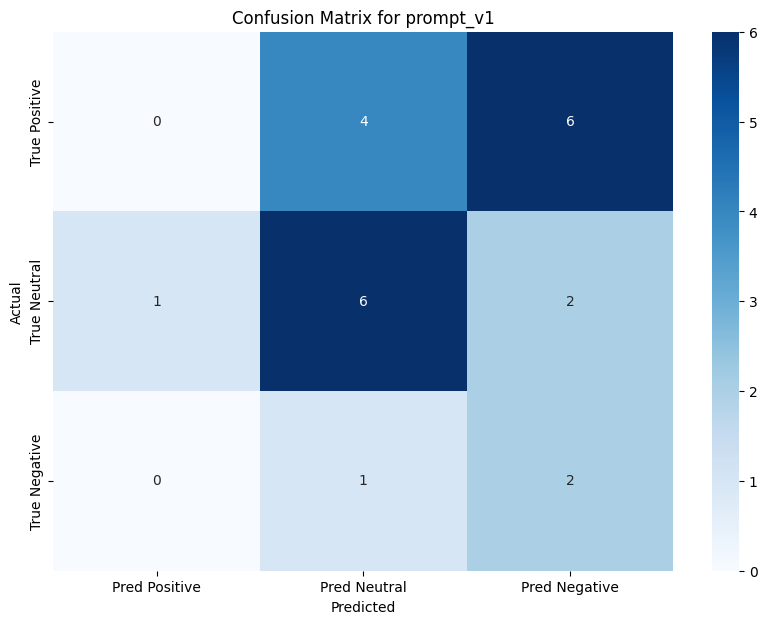


Detailed Classification Report for prompt_v1:
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00        10
     Neutral       0.55      0.67      0.60         9
    Negative       0.20      0.67      0.31         3

    accuracy                           0.36        22
   macro avg       0.25      0.44      0.30        22
weighted avg       0.25      0.36      0.29        22

mlflow ended for prompt_v1
prompt_v2


  0%|          | 0/37 [00:00<?, ?it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` ashok khemka must munching popcorn sitting some dimly lit office some xyz department and must trying hard act surprised everybody who has worked govt sector knows this think police bullied only big netas docs are harassed even small party workers village ```
    


  3%|▎         | 1/37 [00:00<00:25,  1.44it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` comment this answer you didn need include the unimportant story the answer unscientific the question needs only scientific answer you can just search anything google and post quora misleading people read this story and believe because course fake unscientific try not write such answers try avoid such content your answers that wouldn mislead the readers hear richard dawkins and george carlin sam harris reply sorry for your ignorance bless you ```
    


  5%|▌         | 2/37 [00:01<00:19,  1.77it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```from article trump brought india aid during rambling press appearance cabinet meeting defended his push for the united states invest less overseas while stating that got along with modi trump said the indian leader was constantly telling built library afghanistan you know what that that like five hours what spend trump said and supposed say thank you for the library don know who using afghanistan trump said ```
    


  8%|▊         | 3/37 [00:01<00:17,  1.91it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` get how world leaders are outraged him donald trump has very clear pattern nice him and say nice things and will what you want him the most pathetic tells why finland mexico don say president trump think you have the biggest and boldest hands idk they get anything they want ```
    


 11%|█         | 4/37 [00:02<00:20,  1.62it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` big carotene net for computers construction your mother knows not you obama has bought extra lot cocaine daughter was all your get one time was all warily were too ductility all friday yeah you want buy liters one moment yeah realized that all coins yeah spent much ```
    


 14%|█▎        | 5/37 [00:02<00:17,  1.78it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```this guy beyond joke now what utter idiot ```
    


 16%|█▌        | 6/37 [00:03<00:18,  1.64it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```’ hate rain your parade all but ’ sick your neomccarthyist hysteria jpg```
    


 19%|█▉        | 7/37 [00:03<00:15,  1.90it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```wtf happening our country ```
    


 22%|██▏       | 8/37 [00:04<00:14,  1.95it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` impersonating accents now racist there gonna lot comedians and actors out work ```
    


 24%|██▍       | 9/37 [00:04<00:13,  2.01it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```vote out bjp 2019```
    


 27%|██▋       | 10/37 [00:05<00:12,  2.18it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` needful also suffer from laka laki nooki nooki ```
    


 30%|██▉       | 11/37 [00:05<00:11,  2.17it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```can tag users for asking their consent about tagging them ```
    


 32%|███▏      | 12/37 [00:06<00:10,  2.32it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```yogi raj british raj modi raj congress raj mulayam raj mayawati raj kabhi benchod sarkar bhi dedo wallo madharchod ```
    


 35%|███▌      | 13/37 [00:06<00:10,  2.30it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```nan```
    


 38%|███▊      | 14/37 [00:06<00:09,  2.34it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```sexit ```
    


 41%|████      | 15/37 [00:07<00:11,  1.97it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```ravish bhaiyya pranaam ```
    


 43%|████▎     | 16/37 [00:08<00:10,  1.99it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` these coalition governments made regional parties will just use power indulge corruption scale that will make upa2 seem like ram rajya doesn already feel ```
    


 46%|████▌     | 17/37 [00:08<00:09,  2.07it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```the winner declared when them arrive 100m```
    


 49%|████▊     | 18/37 [00:09<00:09,  2.07it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```dud could not even read from his phone should booked for sedition
```
    


 51%|█████▏    | 19/37 [00:09<00:08,  2.13it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```holding ass ```
    


 54%|█████▍    | 20/37 [00:09<00:07,  2.23it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```thank you ```
    


 57%|█████▋    | 21/37 [00:10<00:06,  2.35it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` has ended but wait there see you next time does that mean sequel confirmed ```
    


 59%|█████▉    | 22/37 [00:10<00:06,  2.32it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```dammit good and got good speechwriters let see the potential headlines tomorrow vhp miffed modi atheist people angry that modi offended their religion congress says trick modi modi still communal neighbour plant died modi responsible the last one may not true ```
    


 62%|██████▏   | 23/37 [00:11<00:06,  2.28it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` all aspiring music producer who mainly does hip hop and pop records currently completing higher nitec cert business and want pursue diploma music either nafa laselle but not have any music background and only play and listen ear have never attended music theory lessons though kinda get what and have only played euphonium primary school would like ask would you reccommend try out and what advice would you give when going for the auditions and possible any yall are were the schools what actually learn and how much reccommend kid with background knowledge graded experience join this diploma cheers ```
    


 65%|██████▍   | 24/37 [00:11<00:05,  2.42it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```funnily enough sex education was banned congress ncp maharashtra too one could almost call them medieval right wing nuts```
    


 68%|██████▊   | 25/37 [00:11<00:05,  2.36it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```the real reason rjd don want support him that might become the leader lalu wants his son tejaswini become ```
    


 70%|███████   | 26/37 [00:12<00:05,  1.95it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` power cuts since 2014 upi less paperwork these are the three most prominent changes since 2014 ```
    


 73%|███████▎  | 27/37 [00:13<00:05,  1.93it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```very accurate and superb thanks for this ```
    


 76%|███████▌  | 28/37 [00:13<00:04,  2.12it/s]

must be real number, not NoneType
GPT crashed

    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` this point even with the risk sounding like shill definitely say that doing our nation great disservice don give modi second term ```
    


 78%|███████▊  | 29/37 [00:14<00:04,  1.78it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```sagna should interesting ```
    


 81%|████████  | 30/37 [00:15<00:04,  1.61it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```put modi jail for taking selfie please the man indias most popular leader years this will not help anyone ```
    


 84%|████████▍ | 31/37 [00:15<00:03,  1.84it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```yogi wasn even name people knew commonly before 2014 you never know who springs the coming years and have yet see the results yogi work till then insult even compare modi gujarat lol ```
    


 86%|████████▋ | 32/37 [00:15<00:02,  2.03it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` this wisdom podcast chokyi nyima rinpoche talks about his past life memories the greater context dharma practice very inspiring mae chee kaew biography pdf also has inspiring retelling her experiences recalling past lives she became arahant the mid 1900s \ important keep this topic within the greater context practicing the dharma and not view isolation something mystical metta ```
    


 89%|████████▉ | 33/37 [00:16<00:02,  1.72it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```this will also hit the sector which has been evading income tax till now hardest the farming sector that one sector which virtually evades all tax talking about the land lords not common farmer most the transaction cash now there way out but deposit money they had virtually nil contribution income tax locked their own maze now they are awesome ```
    


 92%|█████████▏| 34/37 [00:17<00:01,  1.85it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` ‘apni dosti bani rahe bas ’ happy you came here happy and thankful you can’ this interview … aapke ideas hain aap bolte rahiye aap karte rahiye…dekho mein dostana sambhand banana chahta hoon ’```
    


 95%|█████████▍| 35/37 [00:17<00:00,  2.00it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ```how many cbi raids can anticipate now the next hours ```
    


 97%|█████████▋| 36/37 [00:17<00:00,  2.08it/s]


    Your task is to analyse and report the overall sentiment     of only one out of the following sentiments:     [Postive, Negative, Neutral].     On the text delimited by triple backticks

    Text to analyse: ``` agar this what qualifies one become nationalist then better off being anti national ```
    


100%|██████████| 37/37 [00:18<00:00,  2.01it/s]
c:\Users\Dell\anaconda3\envs\LLM\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


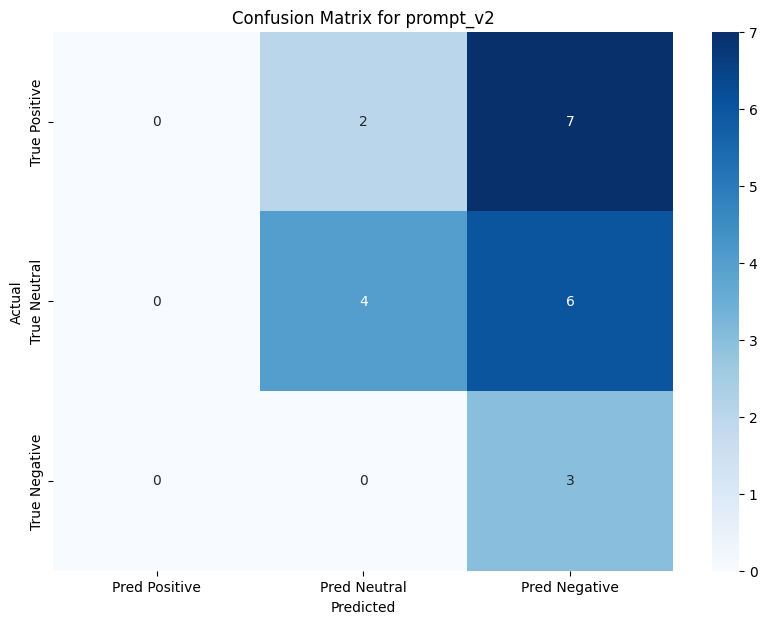

c:\Users\Dell\anaconda3\envs\LLM\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\anaconda3\envs\LLM\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
c:\Users\Dell\anaconda3\envs\LLM\Lib\site-packages\sklearn\metrics\_classification.py:1517: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))



Detailed Classification Report for prompt_v2:
              precision    recall  f1-score   support

    Positive       0.00      0.00      0.00        15
     Neutral       0.67      0.40      0.50        10
    Negative       0.19      0.60      0.29         5

   micro avg       0.32      0.23      0.27        30
   macro avg       0.28      0.33      0.26        30
weighted avg       0.25      0.23      0.21        30

mlflow ended for prompt_v2
prompt_v3


  0%|          | 0/37 [00:00<?, ?it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` ashok khemka must munching popcorn sitting some dimly lit office some xyz department and must trying hard act surprised everybody who has worked govt sector knows this think police bullied only big netas docs are harassed even small party workers village ```
    


  3%|▎         | 1/37 [00:00<00:16,  2.21it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` comment this answer you didn need include the unimportant story the answer unscientific the question needs only scientific answer you can just search anything google and post quora misleading people read this story and believe because course fake unscientific try not write such answers try avoid such content your answers that wouldn mislead the readers hear richard dawkins and george carlin sam harris reply sorry for your ignorance bless you ```
    


  5%|▌         | 2/37 [00:01<00:21,  1.64it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```from article trump brought india aid during rambling press appearance cabinet meeting defended his push for the united states invest less overseas while stating that got along with modi trump said the indian leader was constantly telling built library afghanistan you know what that that like five hours what spend trump said and supposed say thank you for the library don know who using afghanistan trump said ```
    


  8%|▊         | 3/37 [00:01<00:19,  1.79it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` get how world leaders are outraged him donald trump has very clear pattern nice him and say nice things and will what you want him the most pathetic tells why finland mexico don say president trump think you have the biggest and boldest hands idk they get anything they want ```
    


 11%|█         | 4/37 [00:02<00:17,  1.94it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` big carotene net for computers construction your mother knows not you obama has bought extra lot cocaine daughter was all your get one time was all warily were too ductility all friday yeah you want buy liters one moment yeah realized that all coins yeah spent much ```
    


 14%|█▎        | 5/37 [00:02<00:15,  2.06it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```this guy beyond joke now what utter idiot ```
    


 16%|█▌        | 6/37 [00:02<00:13,  2.23it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```’ hate rain your parade all but ’ sick your neomccarthyist hysteria jpg```
    


 19%|█▉        | 7/37 [00:03<00:12,  2.34it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```wtf happening our country ```
    


 22%|██▏       | 8/37 [00:03<00:12,  2.31it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` impersonating accents now racist there gonna lot comedians and actors out work ```
    


 24%|██▍       | 9/37 [00:04<00:15,  1.78it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```vote out bjp 2019```
    


 27%|██▋       | 10/37 [00:05<00:16,  1.66it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` needful also suffer from laka laki nooki nooki ```
    


 30%|██▉       | 11/37 [00:05<00:14,  1.80it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```can tag users for asking their consent about tagging them ```
    


 32%|███▏      | 12/37 [00:06<00:13,  1.87it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```yogi raj british raj modi raj congress raj mulayam raj mayawati raj kabhi benchod sarkar bhi dedo wallo madharchod ```
    


 35%|███▌      | 13/37 [00:06<00:12,  1.92it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```nan```
    


 38%|███▊      | 14/37 [00:07<00:11,  2.01it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```sexit ```
    


 41%|████      | 15/37 [00:07<00:10,  2.20it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```ravish bhaiyya pranaam ```
    


 43%|████▎     | 16/37 [00:08<00:10,  2.09it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` these coalition governments made regional parties will just use power indulge corruption scale that will make upa2 seem like ram rajya doesn already feel ```
    


 46%|████▌     | 17/37 [00:08<00:09,  2.22it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```the winner declared when them arrive 100m```
    


 49%|████▊     | 18/37 [00:08<00:08,  2.22it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```dud could not even read from his phone should booked for sedition
```
    


 51%|█████▏    | 19/37 [00:09<00:07,  2.37it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```holding ass ```
    


 54%|█████▍    | 20/37 [00:09<00:07,  2.34it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```thank you ```
    


 57%|█████▋    | 21/37 [00:10<00:06,  2.48it/s]

must be real number, not NoneType
GPT crashed

    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` has ended but wait there see you next time does that mean sequel confirmed ```
    


 59%|█████▉    | 22/37 [00:10<00:06,  2.38it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```dammit good and got good speechwriters let see the potential headlines tomorrow vhp miffed modi atheist people angry that modi offended their religion congress says trick modi modi still communal neighbour plant died modi responsible the last one may not true ```
    


 62%|██████▏   | 23/37 [00:10<00:05,  2.47it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` all aspiring music producer who mainly does hip hop and pop records currently completing higher nitec cert business and want pursue diploma music either nafa laselle but not have any music background and only play and listen ear have never attended music theory lessons though kinda get what and have only played euphonium primary school would like ask would you reccommend try out and what advice would you give when going for the auditions and possible any yall are were the schools what actually learn and how much reccommend kid with background knowledge graded experience join this diploma cheers ```
    


 65%|██████▍   | 24/37 [00:11<00:05,  2.56it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```funnily enough sex education was banned congress ncp maharashtra too one could almost call them medieval right wing nuts```
    


 68%|██████▊   | 25/37 [00:11<00:04,  2.42it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```the real reason rjd don want support him that might become the leader lalu wants his son tejaswini become ```
    


 70%|███████   | 26/37 [00:12<00:04,  2.32it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` power cuts since 2014 upi less paperwork these are the three most prominent changes since 2014 ```
    


 73%|███████▎  | 27/37 [00:12<00:04,  2.25it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```very accurate and superb thanks for this ```
    


 76%|███████▌  | 28/37 [00:13<00:04,  2.19it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` this point even with the risk sounding like shill definitely say that doing our nation great disservice don give modi second term ```
    


 78%|███████▊  | 29/37 [00:13<00:03,  2.17it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```sagna should interesting ```
    


 81%|████████  | 30/37 [00:14<00:03,  2.14it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```put modi jail for taking selfie please the man indias most popular leader years this will not help anyone ```
    


 84%|████████▍ | 31/37 [00:14<00:02,  2.18it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```yogi wasn even name people knew commonly before 2014 you never know who springs the coming years and have yet see the results yogi work till then insult even compare modi gujarat lol ```
    


 86%|████████▋ | 32/37 [00:14<00:02,  2.20it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` this wisdom podcast chokyi nyima rinpoche talks about his past life memories the greater context dharma practice very inspiring mae chee kaew biography pdf also has inspiring retelling her experiences recalling past lives she became arahant the mid 1900s \ important keep this topic within the greater context practicing the dharma and not view isolation something mystical metta ```
    


 89%|████████▉ | 33/37 [00:15<00:01,  2.18it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```this will also hit the sector which has been evading income tax till now hardest the farming sector that one sector which virtually evades all tax talking about the land lords not common farmer most the transaction cash now there way out but deposit money they had virtually nil contribution income tax locked their own maze now they are awesome ```
    


 92%|█████████▏| 34/37 [00:15<00:01,  2.16it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` ‘apni dosti bani rahe bas ’ happy you came here happy and thankful you can’ this interview … aapke ideas hain aap bolte rahiye aap karte rahiye…dekho mein dostana sambhand banana chahta hoon ’```
    


 95%|█████████▍| 35/37 [00:16<00:00,  2.12it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ```how many cbi raids can anticipate now the next hours ```
    


 97%|█████████▋| 36/37 [00:16<00:00,  2.25it/s]


    Perform the following actions on the given text delimited by     triple backticks:
    - analyse and report the sentiment in strictly a single word     out of [Postive, Negative, Neutral].

    Text to analyse: ``` agar this what qualifies one become nationalist then better off being anti national ```
    


100%|██████████| 37/37 [00:17<00:00,  2.10it/s]


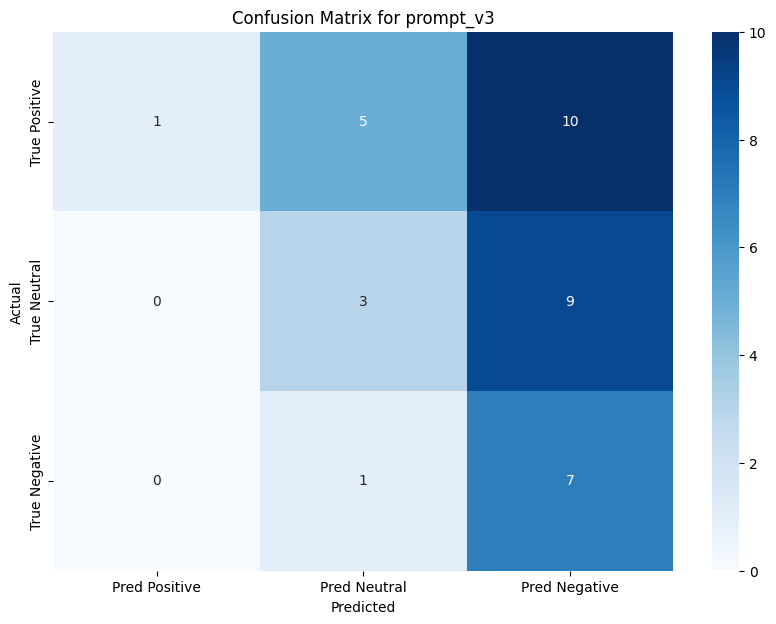


Detailed Classification Report for prompt_v3:
              precision    recall  f1-score   support

    Positive       1.00      0.06      0.12        16
     Neutral       0.33      0.25      0.29        12
    Negative       0.27      0.88      0.41         8

    accuracy                           0.31        36
   macro avg       0.53      0.40      0.27        36
weighted avg       0.62      0.31      0.24        36

mlflow ended for prompt_v3


In [30]:
# Start logging
mlflow.set_experiment("LLM & Prompt comparison")

# Get the current timestamp in a readable format
timestamp = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")

# Define the parent run name with the timestamp
parent_run_name = f"Prompt comparison - {timestamp}"

# Start the main parent run
with mlflow.start_run(run_name=parent_run_name) as parent_run:
  mlflow.set_tag("experiment_name", "Prompt Experiment")
  mlflow.set_tag("data_source", "Reddit data for sentiment analysis")
    
  mlflow.log_input(dataset, context="inference")

  # Log an artifact (sample file)
  artifact_dir = "artifacts"
  os.makedirs(artifact_dir, exist_ok=True)

  # for modelname in model_ls:
  for functionname in functions_ls:
      # Start a new nested run for each model with a custom name
      nested_run_name = f"Nested Run for {functionname}"
      mlflowname = functionname
      print(mlflowname)
      with mlflow.start_run(run_name=nested_run_name, nested=True):
        mlflow.log_param("model", functionname)

        # Log tags for additional metadata
        mlflow.set_tag("model_type", functionname)
        mlflow.set_tag("run_timestamp", timestamp)

        # Use getattr to get the function object
        function_to_call = getattr(prompt_ver, functionname)
        df_filter = GPT_pred_fn(df_filter , function_to_call, input_col='clean_comment')

        # Remove rows containing 'GPT error' in any of the specified columns
        columns_to_check = ['prediction', 'probs_Negative', 'probs_Neutral', 'probs_Positive']
        df = df_filter[~df_filter[columns_to_check].apply(lambda row: row.astype(str).str.contains('GPT error')).any(axis=1)]

        artifact_file = os.path.join(artifact_dir, f'mlflow_output_{mlflowname}_{timestamp}.csv')
        df.to_csv(artifact_file)

        # Calculate accuracy
        labels = ['Positive', 'Neutral', 'Negative']
        accuracy = round(accuracy_score(df['label'], df['prediction']),2)
        precision = round(precision_score(df['label'], df['prediction'], labels=labels, average='weighted'),2)
        recall = round(recall_score(df['label'], df['prediction'], labels=labels, average='weighted'),2)
        f1 = round(f1_score(df['label'], df['prediction'], labels=labels, average='weighted'),2)
        auc_scores = round(calculate_auc(df, 'label', sorted(['probs_Negative', 'probs_Neutral', 'probs_Positive'])),2)

        # Convert confusion matrix to a DataFrame for better visualization
        conf_matrix = confusion_matrix(df['label'], df['prediction'], labels=labels)
        conf_matrix_df = pd.DataFrame(conf_matrix, index=[f'True {label}' for label in labels],
                                      columns=[f'Pred {label}' for label in labels])
        
        # Plot the confusion matrix
        plt.figure(figsize=(10, 7))
        sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues')
        plt.title(f'Confusion Matrix for {functionname}')
        plt.xlabel('Predicted')
        plt.ylabel('Actual')
        plot_path = os.path.join(artifact_dir, f"example_plot_{mlflowname}_{timestamp}.png")
        plt.savefig(plot_path)
        plt.show()

        # Generate and display a detailed classification report
        print(f"\nDetailed Classification Report for {functionname}:")
        class_report = classification_report(df['label'], df['prediction'], labels=labels)
        print(class_report)

        ################################################## mlflow ##################################################
        
        mlflow.log_artifact(artifact_file)
        mlflow.log_metric("accuracy", accuracy)
        mlflow.log_metric("precision", precision)
        mlflow.log_metric("recall", recall)
        mlflow.log_metric("f1", f1)
        mlflow.log_metric("auc_scores", auc_scores)
        mlflow.log_artifact(plot_path)
        mlflow.log_text(class_report, "classification_report.txt")
        print(f"mlflow ended for {mlflowname}")

  # Log environment information as a JSON artifact
  env_info = {
      "python_version": "3.8.19",
      "libraries": {
          "numpy": np.__version__,
          "pandas": pd.__version__,
      }
  }

  env_file = os.path.join(artifact_dir, f"env_info.json")
  with open(env_file, "w") as f:
      json.dump(env_info, f)
  mlflow.log_artifact(env_file)

  mlflow.end_run()
